# P1 Image Denoising

## Will Koehrsen wjk68

In [27]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imtool
from scipy.signal import convolve2d as conv2d

import matplotlib
matplotlib.rc('axes.spines', top=False, bottom=False, left=False, right=False);
matplotlib.rc('axes', facecolor=(1, 1, 1, 0), edgecolor=(1, 1, 1, 0))
matplotlib.rc(('xtick', 'ytick'), color=(1, 1, 1,0))

from IPython.core.pylabtools import figsize

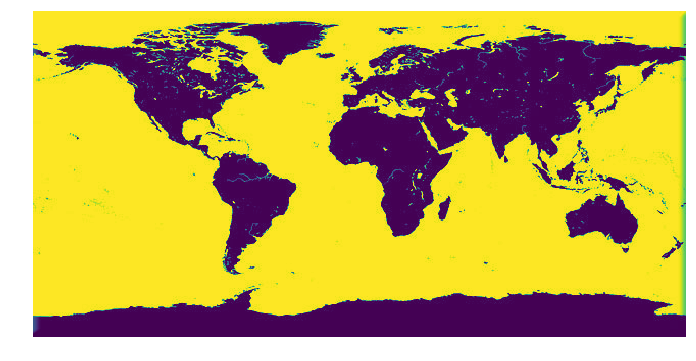

In [66]:
figsize(12, 6)
img = imtool.imread('img/world_binary.jpg')[:, :, 2]
plt.imshow(img); 

## Add Noise to Image

In [69]:
def addnoise(imorg, nratio=0.1):
    imnsy = imorg.copy()
    # convert '0' to '-1'
    imnsy[imnsy == 0] = -1
    # create random value to indicate flipping pixels
    index = np.random.rand(*imnsy.shape)
    # flip pixels to generate noisy image
    imnsy[index < nratio] *= -1
    
    return imnsy

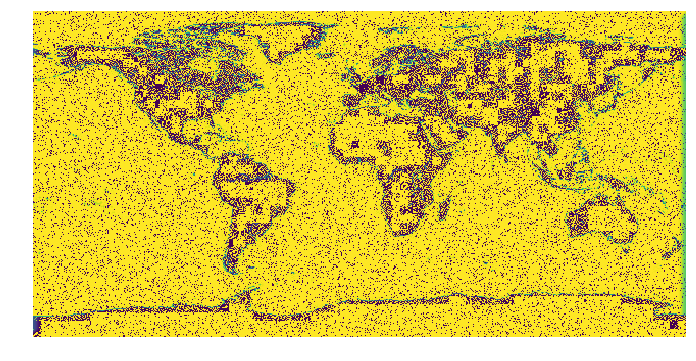

In [70]:
im_noisy = addnoise(img.astype('int16'))
plt.imshow(im_noisy.astype('uint8'));

In [71]:
def showimgs(*args, ncol=2):
    if not args:
        return
    # initialize figure with specific size
    plt.figure(figsize=(20, 14))
    # compose subplot index
    nrow = np.ceil(len(args) / ncol)
    subindex = nrow * 100 + ncol * 10
    # draw each image in subplot
    for i, img in enumerate(args):
        plt.subplot(subindex + i + 1)
        plt.imshow(img.astype('uint8'))

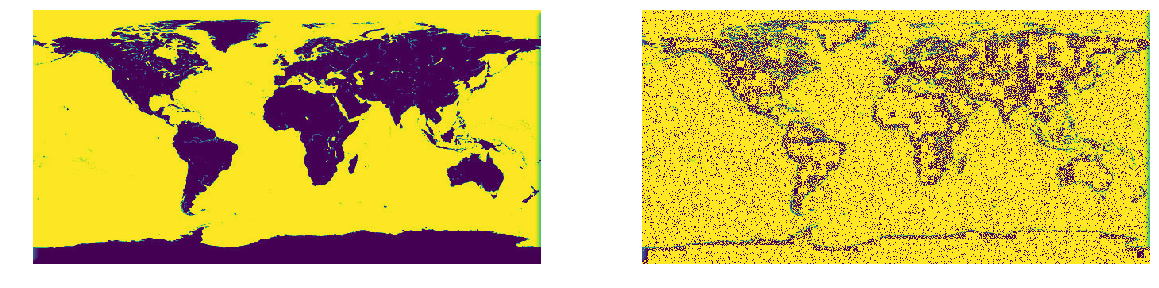

In [72]:
showimgs(img, im_noisy)

# Denoise image

In [73]:
def denoise(imnsy, efunc, showproc = False):
    # initialize recoverred image as noisy image
    imrec = imnsy.copy()
    # show noisy image
    if showproc:
        plt.imshow(imrec, cmap='gray')
        plt.title('Noisy Image')
        plt.show()
    # calculate energy function and its gradients
    E, dE = efunc(imrec, imnsy)
    # initialize temporal energy and iteration count
    Etmp, i = E + 1, 0
    # optimize energy function through iteration
    while Etmp > E:
        Etmp = E
        # update image by flipping all pixels, which could decrease energy function
        imrec[dE < 0] *= -1
        # calculate energy function with revised image
        [E, dE] = efunc(imrec, imnsy)
        # update iteration count
        i += 1
        # show revised image
        if showproc:
            plt.imshow(imrec, cmap='gray')
            plt.title('Recovered Image (Iter-%d)' % i)
            plt.show()
    # map '-1' to 0 in recovered image
    imrec[imrec == -1] = 0
    # return recovered image
    return imrec

In [74]:
def defaultEnergyFunction(hidden, observation, alpha = 1, beta = 1, eta = 1):
    # create filter for beta term
    Tb = np.asarray([[0, 1.0, 0], [1.0, 0, 1.0], [0, 1.0, 0]])
    # calculate beta term in energy function for each pixel
    matB = np.zeros(hidden.shape)
    for i in range(len(hidden)):
        for j in range(len(hidden[0])):
            if i > 0:
                matB[i][j] += hidden[i-1][j]
            if j > 0:
                matB[i][j] += hidden[i][j-1]
            if i < len(hidden) - 1:
                matB[i][j] += hidden[i+1][j]
            if j < len(hidden[0]) - 1:
                matB[i][j] += hidden[i][j+1]
    # calculate energy map
    mapE = hidden * (alpha - beta * matB - eta * observation)
    # get mean of matrix as energy
    E = np.mean(mapE)
    # calculate energy difference map
    dE = -2 * mapE
    
    return E, dE

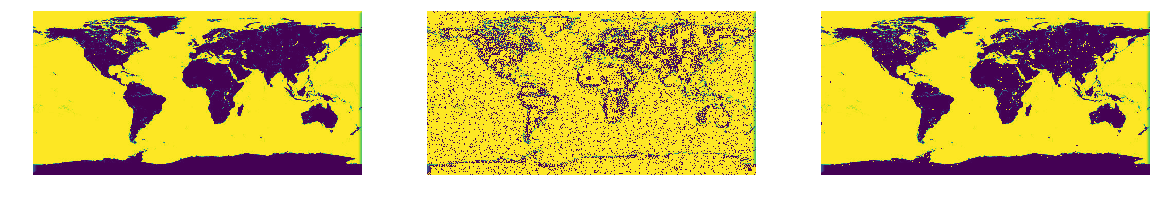

In [75]:
imrec = denoise(im_noisy, defaultEnergyFunction)
showimgs(img, im_noisy, imrec, ncol=3)

In [76]:
def defaultEnergyFunction(hidden, observation, alpha = 1, beta = 1, eta = 1):
    # create filter for beta term
    Tb = np.asarray([[0, 1.0, 0], [1.0, 0, 1.0], [0, 1.0, 0]])
    # convolve hidden image with term B's filter
    matB = conv2d(hidden, Tb, 'same')
    # calculate energy map
    mapE = hidden * (alpha - beta * matB - eta * observation)
    # get mean of matrix as energy
    E = np.mean(mapE)
    # calculate energy difference map
    dE = -2 * mapE
    
    return E, dE

In [77]:
medFilter = lambda hidden, observation: defaultEnergyFunction(hidden, observation,
                                                              alpha=0, beta=1, eta=0)

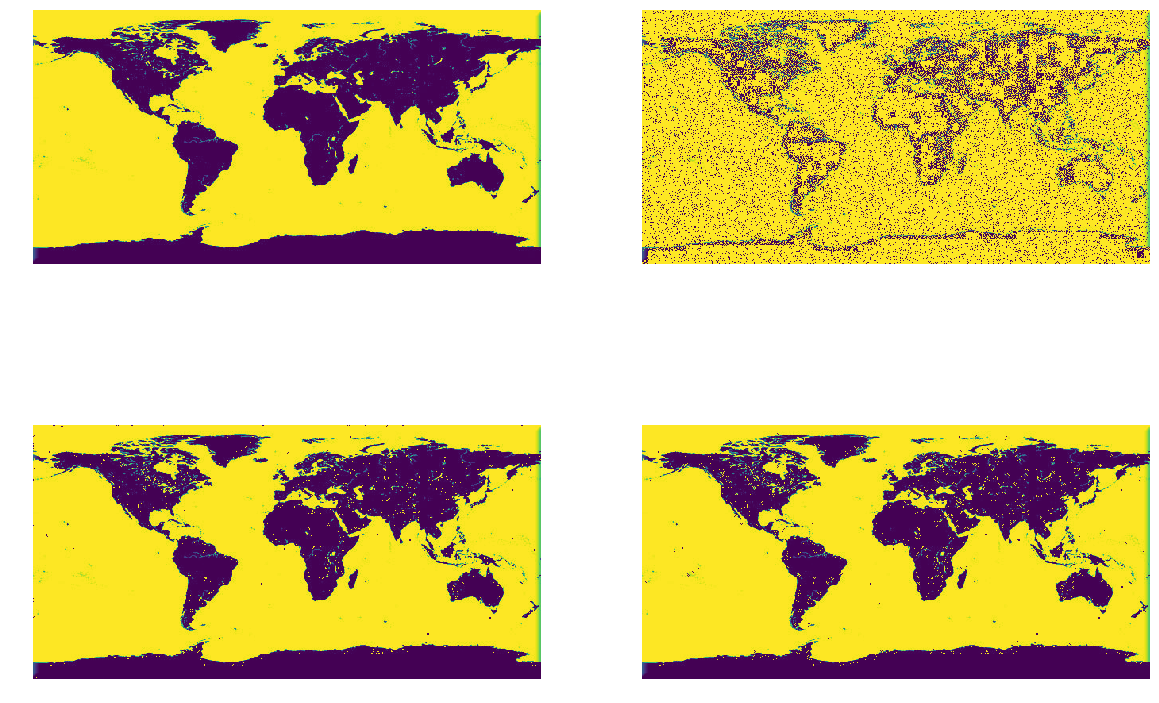

In [78]:
imrecMed = denoise(im_noisy, medFilter)
showimgs(img, im_noisy, imrec, imrecMed)

In [79]:
def extendEnergyFunction(hidden, observation, 
                         alpha=1, beta=1, gamma=1, phi=1, sigma=1, eta=1):
    # template alpha
    Ta = np.asarray([[[-1,-1,-1,-1,1],[-1,-1,-1,1,-1],[-1,-1,0,-1,-1],[-1,1,-1,-1,-1],[1,-1,-1,-1,-1]],
                     [[-1,-1,1,-1,-1],[-1,-1,1,-1,-1],[-1,-1,0,-1,-1],[-1,-1,1,-1,-1],[-1,-1,1,-1,-1]],
                     [[1,-1,-1,-1,-1],[-1,1,-1,-1,-1],[-1,-1,0,-1,-1],[-1,-1,-1,1,-1],[-1,-1,-1,-1,1]],
                     [[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1],[1,1,0,1,1],[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1]]])
    # template beta
    Tb = np.asarray([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
    # template gamma
    Tr = np.asarray([[1,1,1,1,1],[1,0,0,0,1],[1,0,0,0,1],[1,0,0,0,1],[1,1,1,1,1]])
    # template phi
    Tp = np.asarray([[0,0,1,0,0],[0,0,1,0,0],[1,1,0,1,1],[0,0,1,0,0],[0,0,1,0,0]])
    # template sigma
    Ts = np.asarray([[[1,-1,-1,-1,-1],[1,0,-1,-1,-1],[1,1,0,-1,-1],[1,1,1,0,-1],[1,1,1,1,1]],
                     [[1,1,1,-1,-1],[1,1,0,-1,-1],[1,1,0,-1,-1],[1,1,0,-1,-1],[1,1,1,-1,-1]],
                     [[1,1,1,1,1],[1,1,1,0,-1],[1,1,0,-1,-1],[1,0,-1,-1,-1],[1,-1,-1,-1,-1]],
                     [[1,1,1,1,1],[1,1,1,1,1],[1,0,0,0,1],[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1]],
                     [[1,1,1,1,1],[-1,0,1,1,1],[-1,-1,0,1,1],[-1,-1,-1,0,1],[-1,-1,-1,-1,1]],
                     [[-1,-1,1,1,1],[-1,-1,0,1,1],[-1,-1,0,1,1],[-1,-1,0,1,1],[-1,-1,1,1,1]],
                     [[-1,-1,-1,-1,1],[-1,-1,-1,0,1],[-1,-1,0,1,1],[-1,0,1,1,1],[1,1,1,1,1]],
                     [[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1],[1,0,0,0,1],[1,1,1,1,1],[1,1,1,1,1]]])
    
    # generate parameter matrix alpha
    matA = np.empty(hidden.shape)
    for T in Ta:
        matA = np.maximum(matA, hidden * conv2d(hidden, T, 'same'))
    # generate parameter matrix beta
    matB = conv2d(hidden, Tb, 'same')
    # generate parameter matrix gamma
    matR = conv2d(hidden, Tr, 'same')
    # generate parameter matrix phi
    matP = conv2d(hidden, Tp, 'same')
    # generate parameter matrix sigma
    matS = np.empty(hidden.shape)
    for T in Ts:
        matS = np.maximum(matS, hidden * conv2d(hidden, T, 'same'))
        
    # calculate energy map
    mapE = -alpha*matA - sigma*matS - hidden*(beta*matB + gamma*matR + phi*matP + eta*observation)
    # get energy value as mean of map
    E = np.mean(mapE)
    # calculate energy difference map
    dE = -2 * mapE
    
    return E, dE

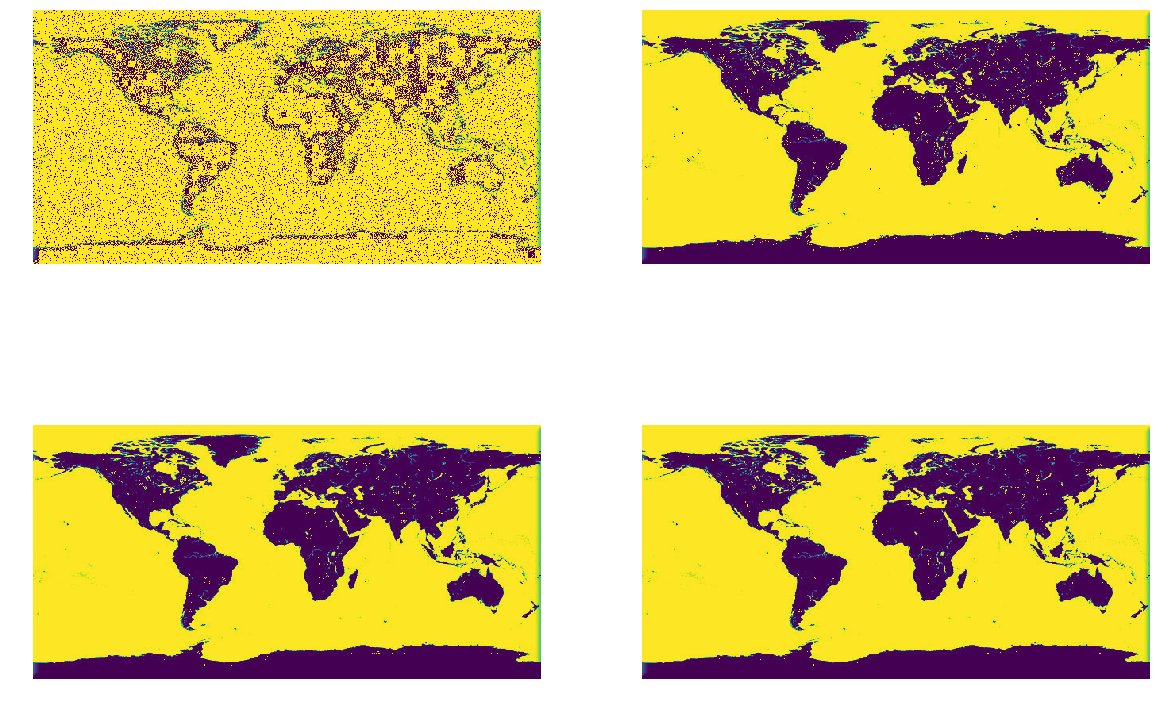

In [80]:
medFilterExt = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                alpha=0, beta=1, gamma=0.1, 
                                                                phi=0, sigma=0, eta=0)

medFilterLarge = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                  alpha=0, beta=0, gamma=0, 
                                                                  phi=1, sigma=0, eta=0)

# denoise image with new energy functions
imrecMedExt = denoise(im_noisy, medFilterExt)
imrecMedLag = denoise(im_noisy, medFilterLarge)

# compare result from different median filter
showimgs(im_noisy, imrecMed, imrecMedExt, imrecMedLag)

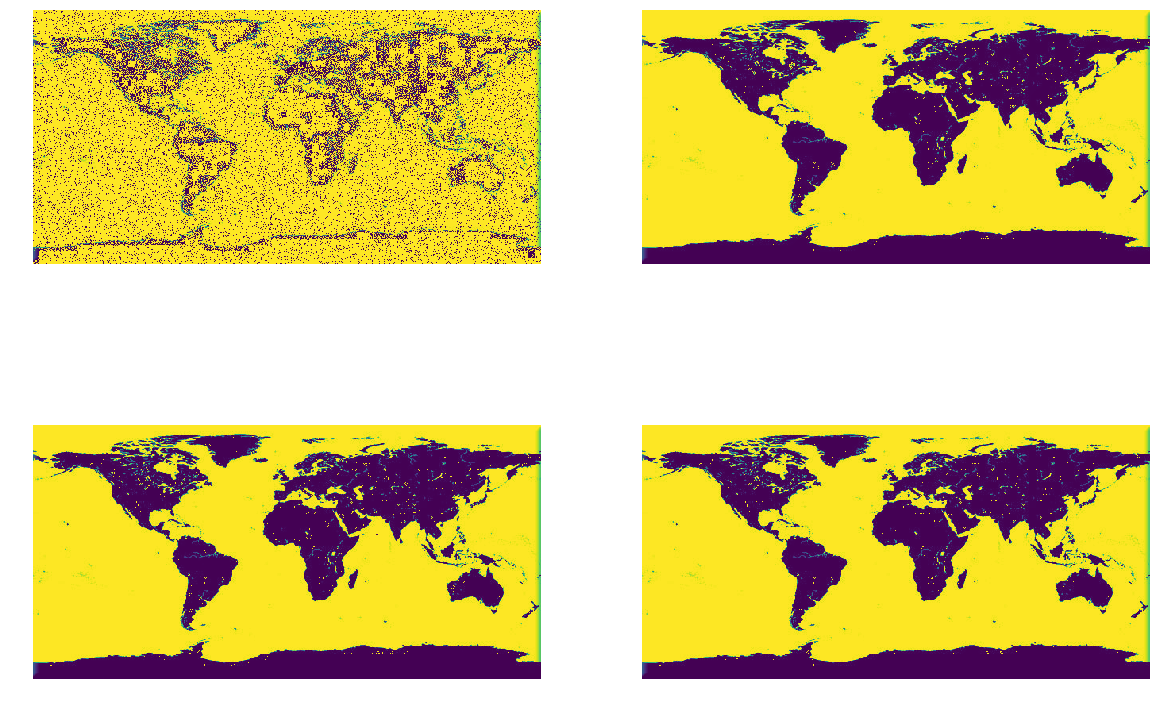

In [81]:
medFilterProtectA = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                     alpha=0.1, beta=1, gamma=0.1, 
                                                                     phi=0, sigma=0, eta=0)

medFilterProtectS = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                     alpha=0, beta=1, gamma=0.1, 
                                                                     phi=0, sigma=0.1, eta=0)

# denoise image with new energy functions
imrecMedProtectA = denoise(im_noisy, medFilterProtectA)
imrecMedProtectS = denoise(im_noisy, medFilterProtectS)

# compare result from different median filter
showimgs(im_noisy, imrecMedExt, imrecMedProtectA, imrecMedProtectS)